In [22]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sparse_stoch_mat_2_pathways as sp_stoch_mat
importlib.reload(sp_stoch_mat)
import sys
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *
import functions
importlib.reload(functions)
from functions import *

## Equation differential of the problem :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{-\text{max}(V_b-V_a,0)+\epsilon_{ab}}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{-\text{max}(V_c-V_b,0)+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{-\text{max}(V_c-V_a,0)+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{-\text{max}(V_a-V_b,0)+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{-\text{max}(V_b-V_c,0)+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\text{max}(V_a-V_c,0)+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [104]:
# Common Parameters :
size = 20
VA0,VB0,VAB01,VAB02= 1.,0.,2.,0.
EAB01,EAB02 = 1.,2.
steepA,steepB,steepAB1,steepAB2 = 1,1,1,1
mu = 1.
kab0=1. # !!!!!!!!!!! this is not an adjustable parameter !!!!!!!!!!!!!!!!!

# stochastic matrix parameters :
X0,Xf,n = 0,size,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print(r'$dx_{SM} =$ '+str(dx))

va = lambda x : VA0/2*(1+np.tanh((x-size/2)*steepA))
vb = lambda x : VB0/2*(1+np.tanh((x-size/2)*steepB))
vab1 = lambda x : VAB01/2*(1+np.tanh((x-size/2)*steepAB1))+EAB01
vab2 = lambda x : VAB02/2*(1+np.tanh((x-size/2)*steepAB2))+EAB02

kab1 = lambda X,*arg : np.array([kab0*(np.exp(-(vab1(x)-va(x)))) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab1(X)-va(X))))
kab2 = lambda X,*arg : np.array([kab0*(np.exp(-(vab2(x)-va(x))+arg[0])) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab2(X)-va(X))+arg[0]))

kba1 = lambda X,*arg : np.array([kab0*(np.exp(-(vab1(x)-vb(x)))) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab1(X)-vb(X))))
kba2 = lambda X,*arg : np.array([kab0*(np.exp(-(vab2(x)-vb(x)))) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab2(X)-vb(X))))

kab = lambda X,*arg : kab1(X,*arg)+kab2(X,*arg)
kba = lambda X,*arg : kba1(X,*arg)+kba2(X,*arg)

#kab = lambda X,*arg : np.array([kab0*(np.exp(-(vab1(x)-va(x)))) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab1(X)-va(X))))
#kba = lambda X,*arg : np.array([kab0*(np.exp(-(vab1(x)-vb(x)))) for x in X]) if type(X)==np.ndarray else kab0*(np.exp(-(vab1(X)-vb(X))))

$dx_{SM} =$ 0.002


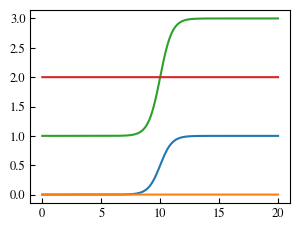

In [105]:
plt.plot(X,va(X))
plt.plot(X,vb(X))
plt.plot(X,vab1(X))
plt.plot(X,vab2(X))

In [106]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(va,vb,kab,kba,0,X0,Xf,n)
rho_a_eq,rho_b_eq = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(va,vb,kab,kba,mu,X0,Xf,n)
rho_a_ooe1,rho_b_ooe1 = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)

In [107]:
rho_a_diff,rho_b_diff = make_eq_distrib(va,vb,np.linspace(X0,Xf,n,endpoint=False))
Z = (sum(rho_a_diff)+sum(rho_b_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff =rho_a_diff/Z,rho_b_diff/Z

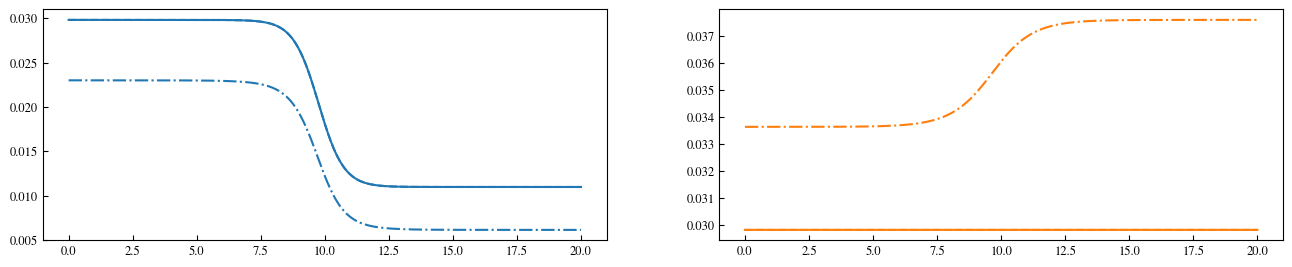

In [108]:
fig,ax = plt.subplots(ncols=2,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,rho_a_diff,color=ColorCycle[0])
ax[1].plot(X,rho_b_diff,color=ColorCycle[1])

ax[0].plot(X,rho_a_eq,color = ColorCycle[0],linestyle='--',label='steep = 1')
ax[1].plot(X,rho_b_eq,color = ColorCycle[1],linestyle='--',label='steep = 1')

ax[0].plot(X,rho_a_ooe1,color = ColorCycle[0],linestyle='-.',label='steep = 1')
ax[1].plot(X,rho_b_ooe1,color = ColorCycle[1],linestyle='-.',label='steep = 1')


## All the equilibrium solutions are consistent
#### Check that the fluxes are 0 for the eq solution, and look at the fluxes for the non-eq solution

In [113]:
def chem_flux (X,rhoa,rhob,kab1,kba2,dx,mu):
    IX = np.array([x//dx for x in X],dtype=int)
    return np.array([rhoa[ix]*kab1(ix*dx,mu)-rhob[ix]*kba2(ix*dx,mu) for ix in IX])
def A_production(X,rhoa,rhob,kab1,kab2,kba1,kba2,dx,mu):
    IX = np.array([x//dx for x in X],dtype=int)
    return np.array([rhoa[ix]*(kab1(ix*dx,mu)+kab2(ix*dx,mu))-rhob[ix]*(kba2(ix*dx,mu)+kba1(ix*dx,mu))for ix in IX])
def D(rho,dx):
    """
    return the derivative of the density along space
    """
    drho = np.zeros(rho.shape[0],dtype=float)
    for i in range(1,rho.shape[0]-1):
        drho[i] = (rho[i+1]-rho[i-1])/(2*dx)
    drho[0] = 0.
    drho[-1] = 0.
    return drho
def diff_flux(rho,V,dx):
    """"
    - rho : is the vector of density in space
    - V is a vector with the value of the potential in the space
    - rho[i] and V[i] are assumed to correspond to the same point in space
    - derivatives at the boundaries are assumed to be 0
    """
    dVx = D(V,dx)
    return D(rho,dx)+rho*dVx

In [114]:
Chem_flux_AB_1 = chem_flux(X,rho_a_ooe1,rho_b_ooe1,kab1,kba2,dx,mu)
A_prod = A_production(X,rho_a_ooe1,rho_b_ooe1,kab1,kab2,kba1,kba2,dx,mu)
diff_flux_A = diff_flux(rho_a_ooe1,va(X),dx)

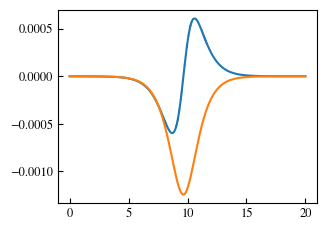

In [116]:
#plt.plot(X,Chem_flux_AB_1)
plt.plot(X,A_prod)
plt.plot(X,diff_flux_A)

In [249]:
print("total diffusive flux A steepness 1 = "+str(np.sum(A_ooe__diff_flux1)*dx))
print("total diffusive flux A steepness 5 = "+str(np.sum(A_ooe__diff_flux5)*dx))
print("total diffusive flux A steepness 10= "+str(np.sum(A_ooe__diff_flux10)*dx))
print()
print("total diffusive flux B steepness 1 = "+str(np.sum(B_ooe__diff_flux1)*dx))
print("total diffusive flux B steepness 5 = "+str(np.sum(B_ooe__diff_flux5)*dx))
print("total diffusive flux B steepness 10= "+str(np.sum(B_ooe__diff_flux10)*dx))
print()
print("total diffusive flux C steepness 1 = "+str(np.sum(C_ooe__diff_flux1)*dx))
print("total diffusive flux C steepness 5 = "+str(np.sum(C_ooe__diff_flux5)*dx))
print("total diffusive flux C steepness 10= "+str(np.sum(C_ooe__diff_flux10)*dx))
print()
print("total diffusive flux total steepness 1 = "+str((np.sum(A_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1) )*dx))
print("total diffusive flux total steepness 5 = "+str((np.sum(A_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5) )*dx))
print("total diffusive flux total steepness 10= "+str((np.sum(A_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10))*dx))

total diffusive flux A steepness 1 = 0.0015100639099572
total diffusive flux A steepness 5 = 0.0013303442749029132
total diffusive flux A steepness 10= 0.0011368381793944997

total diffusive flux B steepness 1 = -0.024366964351971984
total diffusive flux B steepness 5 = -0.024222709037766615
total diffusive flux B steepness 10= -0.024096318935630412

total diffusive flux C steepness 1 = 0.022856900441435894
total diffusive flux C steepness 5 = 0.022892364730559334
total diffusive flux C steepness 10= 0.02295948070523761

total diffusive flux total steepness 1 = 0.047223864792828994
total diffusive flux total steepness 5 = 0.04711507373602158
total diffusive flux total steepness 10= 0.047055799589869725


In [52]:
print("total diffusive flux A steepness 1 = "+str(np.sum(A_ooe__diff_flux1)*dx))
print("total diffusive flux A steepness 5 = "+str(np.sum(A_ooe__diff_flux5)*dx))
print("total diffusive flux A steepness 10= "+str(np.sum(A_ooe__diff_flux10)*dx))
print()
print("total diffusive flux B steepness 1 = "+str(np.sum(B_ooe__diff_flux1)*dx))
print("total diffusive flux B steepness 5 = "+str(np.sum(B_ooe__diff_flux5)*dx))
print("total diffusive flux B steepness 10= "+str(np.sum(B_ooe__diff_flux10)*dx))
print()
print("total diffusive flux C steepness 1 = "+str(np.sum(C_ooe__diff_flux1)*dx))
print("total diffusive flux C steepness 5 = "+str(np.sum(C_ooe__diff_flux5)*dx))
print("total diffusive flux C steepness 10= "+str(np.sum(C_ooe__diff_flux10)*dx))
print()
print("total diffusive flux total steepness 1 = "+str((np.sum(A_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1) )*dx))
print("total diffusive flux total steepness 5 = "+str((np.sum(A_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5) )*dx))
print("total diffusive flux total steepness 10= "+str((np.sum(A_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10))*dx))

total diffusive flux A steepness 1 = -0.0017246234651993979
total diffusive flux A steepness 5 = -0.0013968920777106739
total diffusive flux A steepness 10= -0.0012722030126275626

total diffusive flux B steepness 1 = 0.001636336395228637
total diffusive flux B steepness 5 = 0.001315138916961915
total diffusive flux B steepness 10= 0.0011874481291372079

total diffusive flux C steepness 1 = 0.0001094111089410276
total diffusive flux C steepness 5 = 8.175314448216271e-05
total diffusive flux C steepness 10= 8.475487419728408e-05

total diffusive flux total steepness 1 = -0.0015058012473173426
total diffusive flux total steepness 5 = -0.0012333857887463487
total diffusive flux total steepness 10= -0.0011026932642329943
